# RQ2 - EEG

## Import libraries

In [1]:
import mne
import numpy as np
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tqdm.notebook import tqdm
import fooof

## Load data with the participant Algorithm EEG mapping

In [2]:
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_filtered = df_skill[["Participant", "Algorithm", "SkillScore", "EEG"]]
df_skill = df_skill[["Participant", "SkillScore"]]
df_skill = df_skill.drop_duplicates()
df_filtered

,Participant,Algorithm,SkillScore,EEG
0,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...
1,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...
2,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...
3,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...
4,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...
...,...,...,...,...
1067,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...
1068,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...
1069,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...
1070,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...


## Helper methods for performing PSD and bandpower calculations

In [3]:
def get_spectrum(data, sampling_rate, method='welch', decibel=False, resolution='auto'):
    """
    Calculate amplitude or power spectrum

    data: Should be of shape (n_channels, n_samples)
    sampling_rate: Sampling rate... (float)
    method:
        * welch for power spectrum using Welch's method (recommended)
        * ft for simple Fourier transform (amplitude spectrum)
        * ps for power spectrum using a simple fourier transform
    decibel: Convert spectrum to decibel (bool)
    """

    axis = -1

    n_channels, n_samples = data.shape

    if resolution == 'auto':
        n_frequencies = n_samples
    elif isinstance(resolution, (int, float)):
        n_frequencies = np.round(sampling_rate / resolution).astype('int')
    else:
        raise ValueError('\'{}\''.format(resolution))

    # Spectrum
    if method in ['ft', 'ps']:
        # Using FFT
        # Get (complex) spectrum
        spec = np.fft.fft(data, n=n_frequencies, axis=axis)
        freq = np.fft.fftfreq(n_frequencies) * sampling_rate

        # Convert to real positive-sided spectrum
        spec = np.abs(spec)
        nyquist = 0.5 * sampling_rate
        is_positive = np.logical_or(np.logical_and(freq >= 0, freq <= nyquist), freq == -nyquist)
        n_pos = np.sum(is_positive)
        is_positive = np.repeat(is_positive[np.newaxis], n_channels, axis=0)
        spec = np.reshape(spec[is_positive], (n_channels, n_pos))
        freq = np.abs(freq[is_positive])
        is_double = np.logical_and(freq > 0, freq < nyquist)
        is_double = np.repeat(is_double[np.newaxis], n_channels, axis=0)
        spec[is_double] = 2 * spec[is_double]

        if method in ['ps']:
            # Get power spectral density
            spec = (1 / (sampling_rate * n_frequencies)) * spec ** 2

            # Convert to decibel if required
            if decibel:
                spec = _to_decibel(spec)
    elif method in ['welch', 'welch_db']:
        # Using Welch method
        freq, spec = signal.welch(data, sampling_rate, nperseg=n_frequencies, detrend='constant', axis=axis)

        # Convert to decibel if required
        if decibel:
            spec = _to_decibel(spec)
    else:
        raise RuntimeError('Unknown method \'{}\''.format(method))

    return spec, freq

def bandpower(spec, freq, freqband, relative=False):
    """
    Get band power within specified frequency band
    Alternatively: https://raphaelvallat.com/bandpower.html
    """

    spec = np.asarray(spec)
    freq = np.asarray(freq)
    freqband = np.asarray(freqband)

    if spec.ndim != 1:
        raise ValueError('Input \'spec\' bad: {}'.format(spec.shape))

    if freqband.ndim != 1 and freqband.shape[-1] != 2:
        raise ValueError('Input \'freqband\' bad: {}'.format(freqband.shape))

    # Frequency resolution
    step_freq = freq[1] - freq[0]

    # Find closest indices of band in frequency vector
    is_in_freqband = np.logical_and(freq >= min(freqband), freq <= max(freqband))

    # Integral approximation of the spectrum using Simpson's rule
    bp = simps(spec[is_in_freqband], dx=step_freq)

    if relative:
        bp = bp / simps(spec, dx=step_freq)

    return bp



def _to_decibel(spec):
    return 10 * np.log10(spec)

## Calculate Mental Workload for each participant for each algorithm

In [4]:
# sampling rate of the EEG data
sampling_rate = 500
# mock object for baseline of eeg
baseline_expected = 0.7829462
baseline_variance = 0.1231243


# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for idx in tqdm(range(len(df_filtered))):
    algorithm = df_filtered.iloc[idx]["Algorithm"]
    participant = df_filtered.iloc[idx]["Participant"]
    skill_score = df_filtered.iloc[idx]["SkillScore"]
    eeg_path = df_filtered.iloc[idx]["EEG"]

    # read in eeg file
    eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    # events are set every 50 entry to move the window 0.1 seconds every time
    events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # create epochs which have a 3 second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True, verbose='ERROR')

    # calculate Mental Workload for each window
    mwl_array = []

    for epoch_data_raw in epochs:

        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False, resolution='auto')

        # calculate Mental Workload by dividing the power spectrum of the relative theta band power divided by relative alpha band power
        # on channel Fz for theta and Pc for alpha
        theata_power = bandpower(spectrum[channel_names.index("Fz"), :], frequency, [4.0, 8.0], relative=True)
        alpha_power = bandpower(spectrum[channel_names.index("Pz"), :], frequency, [8.0, 12.0], relative=True)
        MWL = alpha_power / theata_power

        # calculate the baseline_expected_value and variance
        # TODO

        # calculate the mental work load z score
        MWL_z = (MWL - baseline_expected) / baseline_variance

        # append the mental work load z score to the current MWL array
        mwl_array.append(MWL_z)

    # append Mental Workload to the current row
    df_filtered.at[idx, "MentalWorkLoad"] = mwl_array
df_filtered

  0%|          | 0/1072 [00:00<?, ?it/s]

,Participant,Algorithm,SkillScore,EEG,MentalWorkLoad
0,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...,"[3.545770029827546, 4.807234550419257, 6.07874..."
1,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...,"[0.14717985491445165, 0.05745962919270443, -0...."
2,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...,"[-1.6002515525988472, -2.0414610856880233, -2...."
3,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...,"[6.815702070030118, 9.997781735715611, 12.6925..."
4,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...,"[5.899438199890378, 7.076034506115482, 8.04870..."
...,...,...,...,...,...
1067,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...,"[-1.8741911787949173, -1.3881406675290915, -0...."
1068,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...,"[5.04883609096965, 5.287930547030325, 5.239108..."
1069,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...,"[0.03958794630014553, 0.15969785751830537, 0.3..."
1070,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...,"[9.819325496194866, 9.163257705559749, 8.49007..."


# Calculate metrics and stats for MWL

In [5]:
# stats per algorithm per participant
filter = df_filtered.filter(["MWLLength", "MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"])
df_filtered = df_filtered.drop(filter, axis=1)

df_filtered.insert(loc=0, column="MWLLength", value=df_filtered["MentalWorkLoad"].apply(len))
df_filtered.insert(loc=0, column="MWLMean", value=df_filtered["MentalWorkLoad"].apply(np.mean))
df_filtered.insert(loc=0, column="MWLMedian", value=df_filtered["MentalWorkLoad"].apply(np.median))
df_filtered.insert(loc=0, column="MWLStd", value=df_filtered["MentalWorkLoad"].apply(np.std))
df_filtered.insert(loc=0, column="MWLMin", value=df_filtered["MentalWorkLoad"].apply(np.min))
df_filtered.insert(loc=0, column="MWLMax", value=df_filtered["MentalWorkLoad"].apply(np.max))
df_filtered.insert(loc=0, column="MWL_average_slope", value=df_filtered["MentalWorkLoad"].apply(lambda x: np.mean(np.diff(x))))
df_filtered.insert(loc=0, column="MWL_total_slope", value=df_filtered["MentalWorkLoad"].apply(lambda x: np.sum(np.diff(x))))
df_filtered

,MWL_total_slope,MWL_average_slope,MWLMax,MWLMin,MWLStd,MWLMedian,MWLMean,MWLLength,Participant,Algorithm,SkillScore,EEG,MentalWorkLoad
0,2.697019,0.029000,12.862629,-4.317493,4.560981,3.548495,2.770193,94,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...,"[3.545770029827546, 4.807234550419257, 6.07874..."
1,0.659001,0.000441,24.475335,-5.685955,3.973569,-1.061612,-0.026942,1496,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...,"[0.14717985491445165, 0.05745962919270443, -0...."
2,-1.486217,-0.001396,20.136928,-5.169532,3.994951,-1.337969,-0.346622,1066,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...,"[-1.6002515525988472, -2.0414610856880233, -2...."
3,-8.636716,-0.017136,19.288870,-5.095643,4.273108,-1.821014,-0.605415,505,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...,"[6.815702070030118, 9.997781735715611, 12.6925..."
4,-2.980070,-0.006354,15.884724,-3.890231,4.364916,0.401949,1.728053,470,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...,"[5.899438199890378, 7.076034506115482, 8.04870..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,-1.249822,-0.001133,72.641898,-5.516303,11.778666,2.210961,6.014015,1104,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...,"[-1.8741911787949173, -1.3881406675290915, -0...."
1068,-6.459280,-0.013570,18.370343,-5.116210,4.381996,-0.321725,0.665033,477,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...,"[5.04883609096965, 5.287930547030325, 5.239108..."
1069,0.914547,0.000848,15.993376,-5.522951,4.093918,-0.413510,0.411719,1080,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...,"[0.03958794630014553, 0.15969785751830537, 0.3..."
1070,-8.318791,-0.156958,9.819325,-0.619386,2.718237,2.415022,2.898377,54,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...,"[9.819325496194866, 9.163257705559749, 8.49007..."


In [6]:
# stats per participant
df_mwl_participant = df_filtered.groupby(["Participant"]).agg({
    "MWLMean": "mean",
    "MWLMedian": "median",
    "MWLStd": "std",
    "MWLMin": "min",
    "MWLMax": "max",
    "MWL_average_slope": "mean",
    "MWL_total_slope": "mean",})
df_mwl_participant = df_mwl_participant.reset_index()
df_mwl_participant["Participant"] = df_mwl_participant["Participant"].astype(int)
df_mwl_participant = pd.merge(df_mwl_participant, df_skill, on="Participant")
df_mwl_participant

,Participant,MWLMean,MWLMedian,MWLStd,MWLMin,MWLMax,MWL_average_slope,MWL_total_slope,SkillScore
0,1,1.096200,-0.482862,1.649972,-5.685955,54.402377,-0.015240,-2.854743,0.331385
1,2,-3.092688,-3.581653,0.536924,-6.085149,10.361595,0.000558,-0.039168,0.379187
2,3,1.504241,0.118215,2.320654,-5.446428,54.583820,0.000481,-0.489262,0.311264
3,4,-3.731512,-4.309733,0.979730,-6.132404,33.356974,-0.001172,0.065315,0.424727
4,5,-1.890796,-2.648934,0.914519,-5.809644,17.819058,0.005942,1.084456,0.313031
5,6,7.998148,5.823192,2.466902,-5.099546,94.424786,0.001800,3.043607,0.315932
6,7,-0.409023,-1.282351,0.896132,-5.538104,24.992438,0.005914,1.405604,0.420873
7,10,0.177617,-0.452239,1.039220,-5.603965,24.924644,-0.005691,-0.151880,0.350392
8,11,-0.904536,-2.055769,1.815774,-5.790640,43.722482,0.002274,-0.095643,0.178206
9,12,-1.360843,-2.433801,1.733426,-5.970189,85.771897,-0.005970,-1.998094,0.309233


In [7]:
df_mwl_participant.corrwith(df_mwl_participant["SkillScore"])

Participant         -0.049840
MWLMean             -0.198498
MWLMedian           -0.156735
MWLStd              -0.200016
MWLMin              -0.068535
MWLMax              -0.318003
MWL_average_slope    0.012827
MWL_total_slope     -0.005111
SkillScore           1.000000
dtype: float64

In [8]:
# just try if mental workload is visualizable with ocolor mesh, doesnt seem lke it :(
df_tmp = df_filtered.sort_values(by=["Algorithm", "SkillScore"]).reset_index(drop=True)
longest_value = df_tmp["MentalWorkLoad"].apply(len).max()
heatmap_image = np.full((len(df_tmp) + len(df_tmp["Algorithm"].unique()), longest_value), -np.inf)
current_algorithm = ""
current_offset = 0
for idx, row in df_tmp.iterrows():
    if current_algorithm != row["Algorithm"]:
        current_algorithm = row["Algorithm"]
        heatmap_image[idx + current_offset] = np.inf
        current_offset += 1
    heatmap_image[idx+current_offset, :len(row["MentalWorkLoad"])] = row["MentalWorkLoad"]

heatmap_image = np.log(np.abs(heatmap_image))
no_value_mask = heatmap_image == -np.inf
limitter_mask = heatmap_image == np.inf
min = heatmap_image[~no_value_mask].min()
max = heatmap_image[~limitter_mask].max()
#plt.pcolormesh(heatmap_image, cmap="jet", vmin=min, vmax=max)

## Plotting of Mental Workload stats

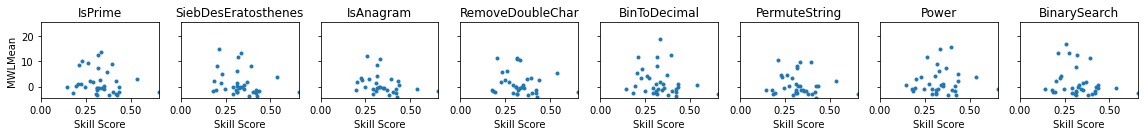

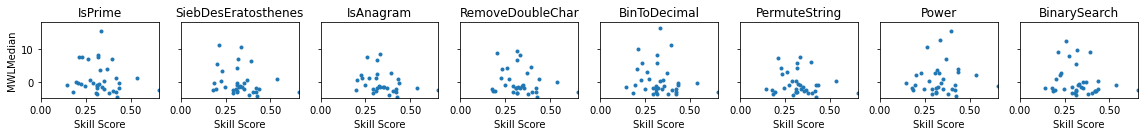

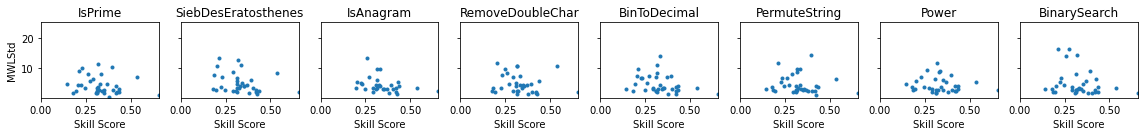

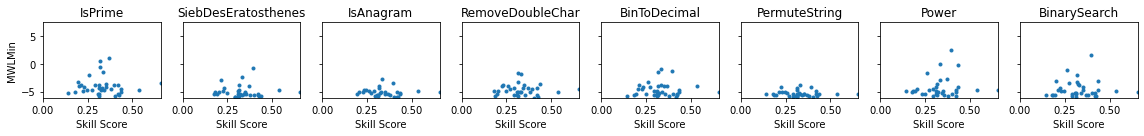

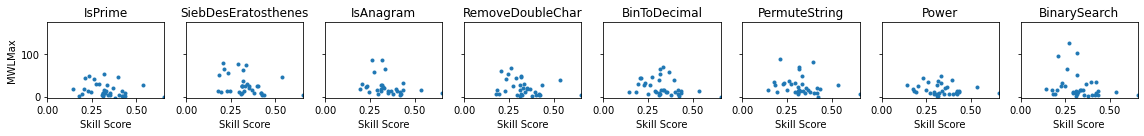

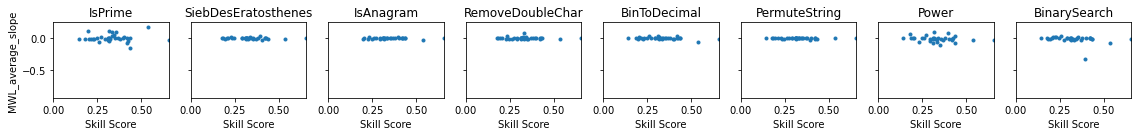

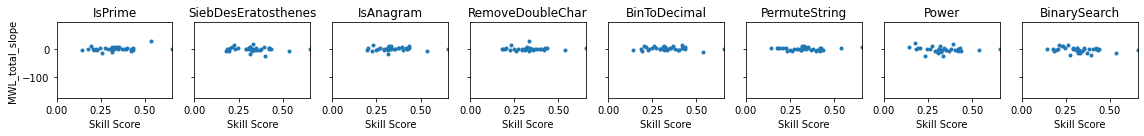

In [9]:
# plot some results
number_of_algorithms = len(df_filtered["Algorithm"].unique())
sample_number = 8

def scatter_plot_metric_skill_score(df, sample_number, column, name=None):
    if name is None:
        name = column
    fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 2, 2))

    for idx, algorithm in enumerate(df["Algorithm"].unique()[:sample_number]):
        df_filtered_algorithm = df[df["Algorithm"] == algorithm]
        ax[idx].plot(df_filtered_algorithm["SkillScore"], df_filtered_algorithm[column], ".")
        ax[idx].set_title(algorithm)
        ax[idx].set_ylabel(name)
        ax[idx].set_xlabel("Skill Score")
        if idx != 0:
            ax[idx].set(ylabel=None)
            ax[idx].set_yticklabels([])
        ax[idx].set_ylim([df_filtered[column].min(), df_filtered[column].max()])
        ax[idx].set_xlim([0, df_filtered["SkillScore"].max()])
    return fig, ax

for column in ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]:
    fig, ax = scatter_plot_metric_skill_score(df_filtered, sample_number, column)
    fig.tight_layout()
    plt.show()


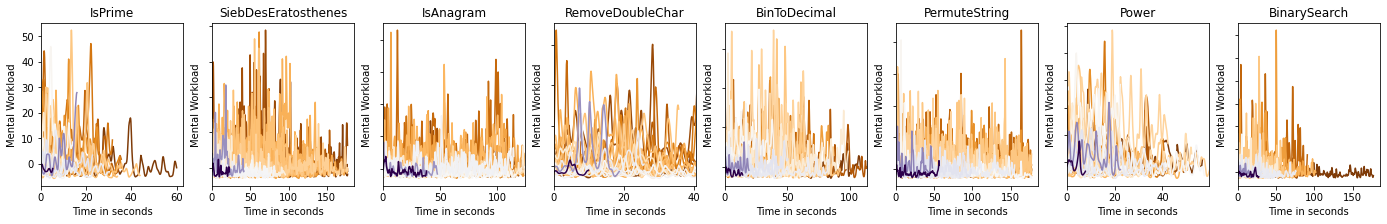

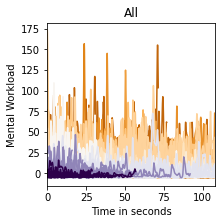

In [11]:
# plot course of mental workload per algorithm

def course_plot_mwl_color_by_skill_score(df, ax, algorithm=None):
    df_algorithm = df[df["Algorithm"] == algorithm]
    if algorithm is None:
        df_algorithm = df
        algorithm = "All"
    df_algorithm = df_algorithm.sort_values(by=["SkillScore"]).reset_index(drop=True)
    min_skill_score = df_algorithm["SkillScore"].min()
    max_skill_score = df_algorithm["SkillScore"].max()
    cm = plt.get_cmap("PuOr")
    for idx, row in df_algorithm.iterrows():
        time = np.linspace(0, len(row["MentalWorkLoad"]), len(row["MentalWorkLoad"]))
        time = time / 10
        color = cm((row["SkillScore"] - min_skill_score) / (max_skill_score - min_skill_score))
        ax.plot(time, row["MentalWorkLoad"], color=color)
        ax.set_xlabel("Time in seconds")
        ax.set_ylabel("Mental Workload")
        ax.set_title(algorithm)
        ax.set_xlim(0, )


fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 3, 3))
for idx, algorithm in enumerate(df_filtered["Algorithm"][:sample_number].unique()):
    course_plot_mwl_color_by_skill_score(df_filtered, ax[idx], algorithm)
    if idx != 0:
        ax[idx].set_yticklabels([])
plt.show()


fig, ax = plt.subplots(figsize=(3, 3))
course_plot_mwl_color_by_skill_score(df_filtered, ax)
plt.show()

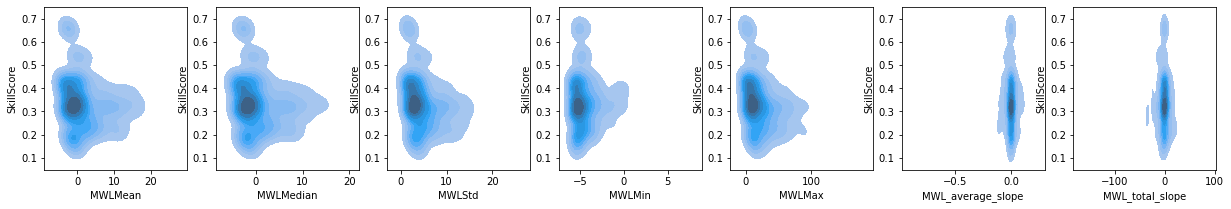

In [12]:
import seaborn as sns

# kdeplot of mental workload vs skill score
columns = ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]
fig, ax = plt.subplots(1, len(columns), figsize=(len(columns) * 3, 3))
for idx, column in enumerate(columns):
    sns.kdeplot(df_filtered[column], y=df_filtered["SkillScore"], ax=ax[idx], label=column, shade=True)
plt.show()

## Generate Topographical Plots

  0%|          | 0/37 [00:00<?, ?it/s]

0; 1; 2; 3; 

KeyboardInterrupt: 

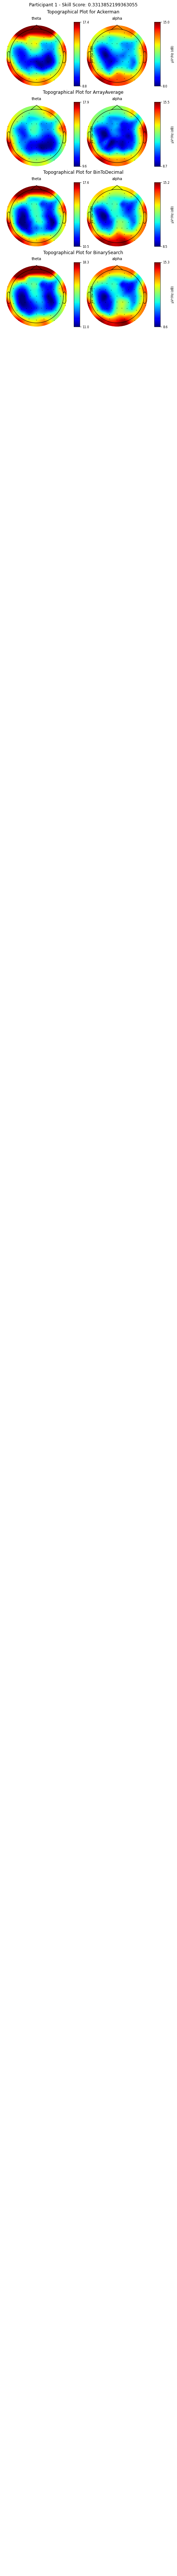

In [25]:
# sampling rate of the EEG data
sampling_rate = 500
# mock object for baseline of eeg
baseline_expected = 0.7829462
baseline_variance = 0.1231243

# read in montage and calculate the electrode positions
montage_path = "./data/EEG/AC-64.bvef"
montage = mne.channels.read_custom_montage(montage_path, head_size=0.085)

# get algorithm names and participants grouping
algo_names = df_filtered["Algorithm"].unique()
algo_names.sort()
participants = df_filtered["Participant"].unique()

# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for participant in tqdm(participants, total=len(participants)):
    df_participant = df_filtered[df_filtered["Participant"] == participant]
    skill_score = df_participant.iloc[0]["SkillScore"]

    # create figure for total topographical plot of all algorithms
    fig = plt.figure(constrained_layout=True, figsize=(6, len(algo_names) * 3))
    fig.suptitle(f"Participant {participant} - Skill Score: {skill_score}")

    # create algo_names subfigures for topographical plots
    subfigures = fig.subfigures(nrows=len(algo_names), ncols=1)

    # get the eeg data for the participant and each algorithm
    for idx, algorithm in enumerate(algo_names):
        print(idx, end="; ")
        df_algorithm = df_participant[df_participant["Algorithm"] == algorithm]

        # set the title of the subfigure
        subfigures[idx].suptitle(f"Topographical Plot for {algorithm}")

        # get the axis object
        ax = subfigures[idx].subplots(nrows=1, ncols=2)

        if len(df_algorithm) == 0:
            continue

        eeg_path = df_algorithm.iloc[0]["EEG"]

        # read in eeg file
        eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

        # set montage
        eeg_data.set_montage(montage)

        # get raw channel data and do mean average referencing
        eeg_data_raw = eeg_data.get_data()
        eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

        # create mock events for cutting eeg data (number, len, id)
        # events are set every 50 entry to move the window 0.1 seconds every time
        events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

        # create temporal eeg raw for cutting data into epochs
        tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

        # create epochs which have a 3 second window and operate on event id 1
        epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True, verbose='ERROR')

        # get the corresponding algorithm index
        epochs.plot_psd_topomap(bands=[(4.0, 8.0, "theta"), (8.0, 12.0, "alpha")], axes=ax, show=False, cmap='jet', verbose='ERROR')
    plt.show()